## MRI preprocessing
The goal of this Notebook is to preprocess all the Magnetic Resonance Images (MRI), which are in NIfTI format (.nii or .nii.gz if zipped).

NIfTI (Neuroimaging Informatics Technology Initiative) files are used to storage MRI images. The file includes the 3D image data, and information about the coordinate system and other metadata. More information about Nifti files can be found [here](https://docs.safe.com/fme/html/FME_Desktop_Documentation/FME_ReadersWriters/nifti/nifti.htm). Library [Nibabel](https://nipy.org/nibabel/gettingstarted.html) is used in Python to work with NIfTI.

The preprocessing includes the following steps:
   - Read NIfTI: extract image data from the file.
   - Remove skull stripping from the 3D image of the brain.
   - Normalize the 3D image.
   - Resize the 3D image.
   - Save the 3D image as numpy’s compressed format (.npz).

This notebook is structured as follows:
   - Import libraries
   - Define functions
   - NIfTI overview
   - Remove skull stripping overview
   - NIfTI files selection
   - NIfTI preprocessing

### Import libraries

In [1]:
import os
import time
import numpy as np
import nibabel as nib
from scipy import ndimage
from aux_functions.aux_functions_visualization import *
from aux_functions.deepbrain_package.extractor import Extractor

In [1]:
import zipfile
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import cv2
import shutil

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context='notebook')
sns.set_style("ticks")

### Define functions

In [2]:
def read_nifti_file(file):
    """
    Read and load nifti file.
    """
    
    # Read file
    volume = nib.load(file)
    
    # Get raw data
    volume = volume.get_fdata()
    
    # Exchange axis 0 and 2
    if volume.shape[1] == volume.shape[2]:
        print(f"{file} has a shape incompatible")
    
    return volume


def remove_skull(volume):
    """
    Extract only brain mass from volume.
    """
    
    # Initialize brain tissue extractor
    ext = Extractor()

    # Calculate probability of being brain tissue
    prob = ext.run(volume) 

    # Extract mask with probability higher than 0.5
    mask = prob > 0.5
    
    # Detect only pixels with brain mass
    volume [mask == False] = 0
    volume = volume.astype("float32")
    
    return volume


def normalize(volume):
    """
    Function used to normalize the volume pixel intensity.
    Input: i
    Output: matrix normalized
    """
    
    I_min = np.amin(volume)
    I_max = np.amax(volume)
    new_min = 0.0
    new_max = 1.0
    
    volume_nor = (volume - I_min) * (new_max - new_min)/(I_max - I_min)  + new_min
    volume_nor = volume_nor.astype("float32")
    
    return volume_nor


def cut_volume(volume):
    """
    Function used to cut the size of a 3D volume.
    Input: volume
    Output: cut volume
    """
    
    if volume.shape[0] == 256:
        volume_new = volume[20:220,30:,:]
    
    if volume.shape[0] == 192:
        volume_new = volume[20:180,20:180,:]
    
    return volume_new


def resize_volume(volume):
    """
    Function used to resize the shape of a volume.
    Input: volume
    Output: resized volume.
    """
    
    # Set the desired depth
    desired_height = 180
    desired_width = 180
    desired_depth = 110
    
    # Get current depth
    current_height = volume.shape[0]
    current_width = volume.shape[1]
    current_depth = volume.shape[2]
    
    # Compute depth factor
    height = current_height / desired_height
    width = current_width / desired_width
    depth = current_depth / desired_depth

    height_factor = 1 / height
    width_factor = 1 / width
    depth_factor = 1 / depth
    
    # Rotate
    #img = ndimage.rotate(img, 90, reshape=False)
    
    # Resize across z-axis
    volume = ndimage.zoom(volume, (height_factor, width_factor, depth_factor), order=1)
    
    return volume


def save_matrix(volume, file, save_path = "./Volume_files/"):
    """
    Function used to save matrix into compressed numpy file.
    Input: matrix processed, original file, path where to save the numpy file
    Output: matrix saved
    """
    
    # Check if save_path folder exists
    if not os.path.exists(save_path):
        os.mkdir(save_path)   

    # Get Image ID from path
    title = file.split("_")[-1].split(".")[0]
    
    # Save volume array
    if os.path.exists(save_path + title + ".npz"):
        print(f"    {title} was already processed.")
    else:
        np.savez_compressed(save_path + title, volume)
    

def process_scan(file, save_path):
    """
    Read, skull stripping and resize Nifti file.
    """
    
    # Read Nifti file
    volume = read_nifti_file(file)
    
    # Extract skull from 3D volume
    volume = remove_skull(volume)
    
    # Cut 3D volume
    #volume = cut_volume(volume)
    
    # Resize width, height and depth
    volume = resize_volume(volume)
    
    # Normalize pixel intensity
    volume = normalize(volume)
    
    # Save 3D matrix
    save_matrix(volume, file, save_path)
    
    return volume

### NIfTI overview

In [3]:
# Specify NIfTI file to analyze
file = "../Datasets/test.nii"

In [4]:
# Read NIfTI file using nibabel library
volume = nib.load(file)

In [5]:
# Check type of file
print(type(volume))

<class 'nibabel.nifti1.Nifti1Image'>


In [6]:
# Check header of the file
print(volume.header)      

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 124   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.      0.9375  0.9375  1.5     0.0143  1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.70710677
quatern_d       : 0.70710677
qoffset_x       : 120.0
qoffset_y       : 89.2
qoffset_z       : -1

In [7]:
# Check shape of the file
print(volume.shape)

(256, 256, 124)


In [8]:
# Check data type of the file
print(volume.get_data_dtype())

int16


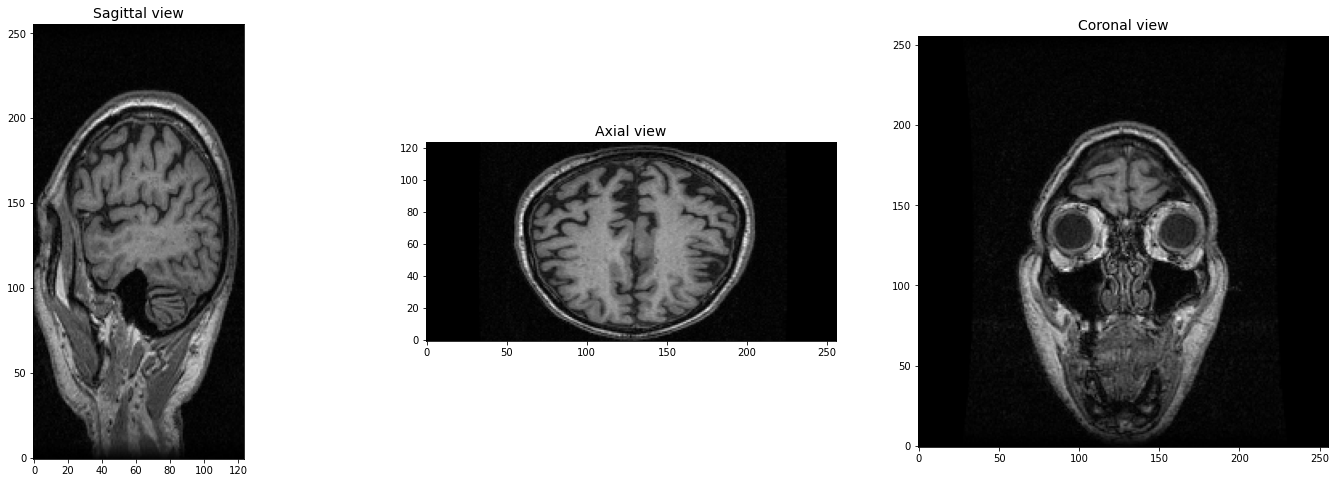

In [9]:
# Visualize slices of the volume
volume_data = volume.get_fdata()
neuro_plot(volume_data, view_ = "all", slice_ = [178, 180, 10])

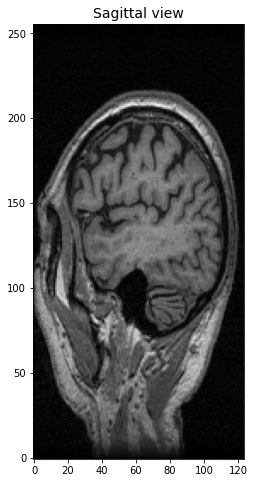

In [10]:
# Visualize first view of the volume
neuro_plot(volume_data, view_ = "sagittal", slice_ = 178)

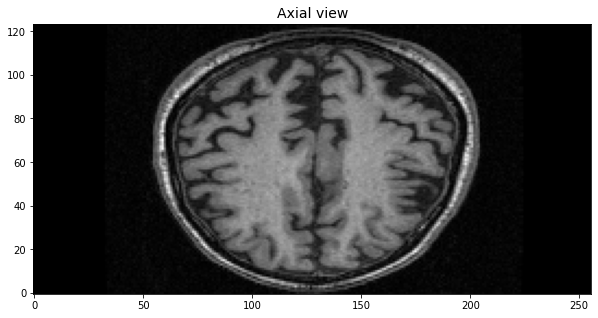

In [11]:
# Visualize second view of the volume
neuro_plot(volume_data, view_ = "axial", slice_ = 180)

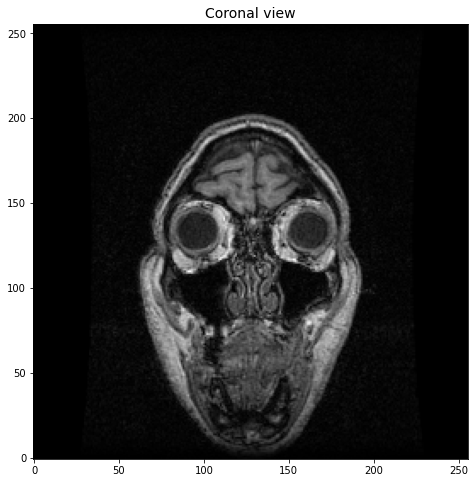

In [12]:
# Visualize third view of the volume
neuro_plot(volume_data, view_ = "coronal", slice_ = 10)

### Skull-stripping overview

In [13]:
# Specify NIfTI file to analyze
file = "../Datasets/test.nii"

In [14]:
# Read NIfTI file using nibabel library
volume = read_nifti_file(file)

In [21]:
# Initialize brain tissue extractor
ext = Extractor()

Instructions for updating:
Use tf.gfile.GFile.


In [22]:
# Calculate probability of being brain tissue
prob = ext.run(volume) 

In [23]:
# Extract mask with probability higher than 0.5
mask = prob > 0.5

In [27]:
# Detect only pixels with brain mass
import copy
volume_cleaned = copy.copy(volume)
volume_cleaned [mask == False] = 0

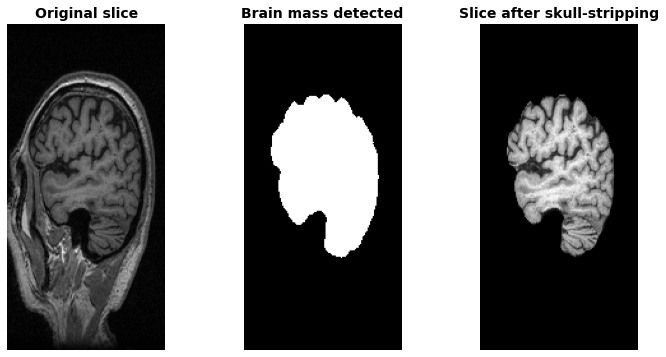

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), sharey=True)
        
axes[0].imshow(volume[80, :, :], cmap="gray", origin="lower")
axes[0].set_title('Original slice', fontsize = 14, fontweight = 'bold')
axes[0].axis('off')
        
axes[1].imshow(mask[80, :, :], cmap="gray", origin="lower")
axes[1].set_title('Brain mass detected', fontsize = 14, fontweight = 'bold')
axes[1].axis('off')     

axes[2].imshow(volume_cleaned[80, :, :], cmap="gray", origin="lower")
axes[2].set_title('Slice after skull-stripping', fontsize = 14, fontweight = 'bold')
axes[2].axis('off');

# Save figure
#plt.savefig('../Results/figures/skull_stripping.png', dpi = 500, transparent = False)

plt.show()

### NIfTI files selection

In [ ]:
counter = 0
shapes = []
counters = [0] * 30
titles_shapes = [[] for i in range(30)]

for index, file in enumerate(os.listdir(new_path)):
    
    # Avoid trigerring .DS_Store (when use macOS)
    if subpath.startswith('.DS_Store'):
        continue
    
    # Read Nifti file
    volume = read_nifti_file(new_path + file)
    
    if volume.shape not in shapes:
        shapes.append(volume.shape)
    
    index_shapes = shapes.index(volume.shape)
    
    counters[index_shapes] += 1 
    
    titles_shapes[index_shapes].append(file.split("_")[-1].split(".")[0])
    
    if index % 50 == 0:
        print(index)

In [ ]:
list_shapes_cleaned = [shape_ for index, shape_ in enumerate(shapes) if counters[index] > 30]
list_counters_cleaned = [counter_ for index, counter_ in enumerate(counters) if counters[index] > 30]
list_titles_cleaned = [title_ for index, title_ in enumerate(titles_shapes) if counters[index] > 30]
list_titles_cleaned = [item for sublist in list_titles_cleaned for item in sublist]

711 from 1100 has shape (256,256) = 64%

### Data preprocessing

#### Specify paths

In [3]:
list_path_mri = ["../Datasets/Files_network/"]
save_path = "../Datasets/Volume_files/"

#### Load list of Images IDs

In [4]:
list_titles_path = '../Datasets/list_titles_cleaned.npz'

In [5]:
list_titles = np.load(list_titles_path, allow_pickle= True)
list_titles = list_titles['arr_0']
list_titles = list(list_titles)

#### Run process

In [6]:
start_time = time.time()

count_volumes = 0

for path in list_path_mri:
    
    print("[+] Current path:", path)
    
    for file in os.listdir(path):
        
        # Avoid trigerring .DS_Store (when use macOS)
        if file.startswith('.DS_Store'):
            continue
        
        title = file.split("_")[-1].split(".")[0]

        if title in list_titles:
            
            # Volume process
            volume = process_scan(path + file, save_path)

            count_volumes += 1

            # Print counter status
            if(count_volumes % 50 == 0):
                print(f"    {count_volumes} volumes processed")
        
print("[+] Total number of volumes processed:", count_volumes)

end_time = time.time()
print("\n[+] Time of process: "+"{:.2f}".format(end_time-start_time));

[+] Current path: ../Datasets/Files_network/
Instructions for updating:
Use tf.gfile.GFile.
    50 volumes processed
    100 volumes processed
    150 volumes processed
    200 volumes processed
    250 volumes processed
    300 volumes processed
    350 volumes processed
    400 volumes processed
    450 volumes processed
    500 volumes processed
    550 volumes processed
    600 volumes processed
    650 volumes processed
    700 volumes processed
    750 volumes processed
    800 volumes processed
    850 volumes processed
    900 volumes processed
    950 volumes processed
    1000 volumes processed
    1050 volumes processed
[+] Total number of volumes processed: 1085

[+] Time of process: 7981.61
